## Xgboost train,testset에서 Class 1중 확률이 0.3~0.6인 sample extraction

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [135]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## 0.3~0.6 modeling

In [3]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [4]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [5]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [7]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [8]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              718935
1              174231
Name: count, dtype: int64
Original data size: 1116458 samples
Undersampled data size: 348462 samples

Undersampling imbalance check
loan_status
0    174231
1    174231
Name: count, dtype: int64


In [9]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

In [11]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

[0]	validation_0-logloss:0.68687	validation_1-logloss:0.68687
[1]	validation_0-logloss:0.68071	validation_1-logloss:0.68073
[2]	validation_0-logloss:0.67468	validation_1-logloss:0.67470
[3]	validation_0-logloss:0.66876	validation_1-logloss:0.66880
[4]	validation_0-logloss:0.66296	validation_1-logloss:0.66301
[5]	validation_0-logloss:0.65727	validation_1-logloss:0.65733
[6]	validation_0-logloss:0.65168	validation_1-logloss:0.65177
[7]	validation_0-logloss:0.64620	validation_1-logloss:0.64631
[8]	validation_0-logloss:0.64083	validation_1-logloss:0.64096
[9]	validation_0-logloss:0.63555	validation_1-logloss:0.63570
[10]	validation_0-logloss:0.63037	validation_1-logloss:0.63055
[11]	validation_0-logloss:0.62529	validation_1-logloss:0.62549
[12]	validation_0-logloss:0.62030	validation_1-logloss:0.62053
[13]	validation_0-logloss:0.61540	validation_1-logloss:0.61567
[14]	validation_0-logloss:0.61059	validation_1-logloss:0.61089
[15]	validation_0-logloss:0.60587	validation_1-logloss:0.60620
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [233]:
# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_test_df = X_test.copy()
X_test_df['y_prob'] = y_prob
X_test_df['y_pred'] = y_pred
X_test_df['actual'] = y_test.values

filtered = X_test_df[(X_test_df['actual'] == 1)&
                     (X_test_df['y_prob']>=0)&
                     (X_test_df['y_prob']<=0.7)]

"""filtered2 = X_test_df[(X_test_df['actual'] == 0)&
                      (X_test_df['y_pred'] == 1)&
                      (X_test_df['y_prob']>=0.5)]"""


print(f"⚠️ 조건에 맞는 샘플 개수 filtered 1: {len(filtered)}")
#print(f"⚠️ 조건에 맞는 샘플 개수 filtered 2: {len(filtered2)}")
#display(filtered.head())  # Jupyter 환경이면 이렇게

⚠️ 조건에 맞는 샘플 개수 filtered 1: 11803


In [18]:
test_data['loan_status'].value_counts()

loan_status
0    299557
1     72596
Name: count, dtype: int64

In [28]:
filtered.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,revol_util,revol_bal,total_acc,credit_history_years,y_prob,y_pred,actual
20,579.0,112.0,0.1153,38000.0,26.34,846.0,277.12,660.0,9000.0,5176.0,1801.000000,0.635,5713.0,10.0,10,0.463981,0,1
31,584.0,39.0,0.1824,50300.0,20.07,24.0,590.25,720.0,5900.0,6294.0,11065.920936,0.201,1184.0,12.0,3,0.452710,0,1
107,559.0,122.0,0.1399,56000.0,27.93,483.0,239.21,665.0,3000.0,2336.0,0.000000,0.970,3008.0,31.0,11,0.502033,1,1
168,664.0,183.0,0.1311,76000.0,25.69,113.0,547.43,735.0,125600.0,7591.0,33170.000000,0.602,75614.0,19.0,16,0.435260,0,1
212,629.0,249.0,0.1333,245000.0,13.59,891.0,802.29,680.0,57100.0,40926.0,1976.000000,0.806,46024.0,28.0,21,0.401548,0,1


In [234]:
drop_columns = ['y_prob', 'y_pred', 'actual']
filtered = filtered.drop(columns=drop_columns)

In [235]:
filtered['loan_status'] = 1

In [236]:
path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
filtered.to_csv(path_or_buf=path+"filtered_class1_0to0.7.csv", index=False)

## undersampling 적용

In [136]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [137]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [138]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [139]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [140]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              718935
1              174231
Name: count, dtype: int64
Original data size: 1116458 samples
Undersampled data size: 348462 samples

Undersampling imbalance check
loan_status
0    174231
1    174231
Name: count, dtype: int64


In [141]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68688	validation_1-logloss:0.68689
[1]	validation_0-logloss:0.68074	validation_1-logloss:0.68076
[2]	validation_0-logloss:0.67472	validation_1-logloss:0.67475
[3]	validation_0-logloss:0.66882	validation_1-logloss:0.66887
[4]	validation_0-logloss:0.66303	validation_1-logloss:0.66310
[5]	validation_0-logloss:0.65736	validation_1-logloss:0.65744
[6]	validation_0-logloss:0.65179	validation_1-logloss:0.65189
[7]	validation_0-logloss:0.64632	validation_1-logloss:0.64645
[8]	validation_0-logloss:0.64096	validation_1-logloss:0.64112
[9]	validation_0-logloss:0.63570	validation_1-logloss:0.63588
[10]	validation_0-logloss:0.63054	validation_1-logloss:0.63075
[11]	validation_0-logloss:0.62548	validation_1-logloss:0.62571
[12]	validation_0-logloss:0.62050	validation_1-logloss:0.62077
[13]	validation_0-logloss:0.61562	validation_1-logloss:0.61592
[14]	validation_0-logloss:0.61082	validation_1-logloss:0.61116
[15]	validation_0-logloss:0.60611	validation_1-logloss:0.60649
[1

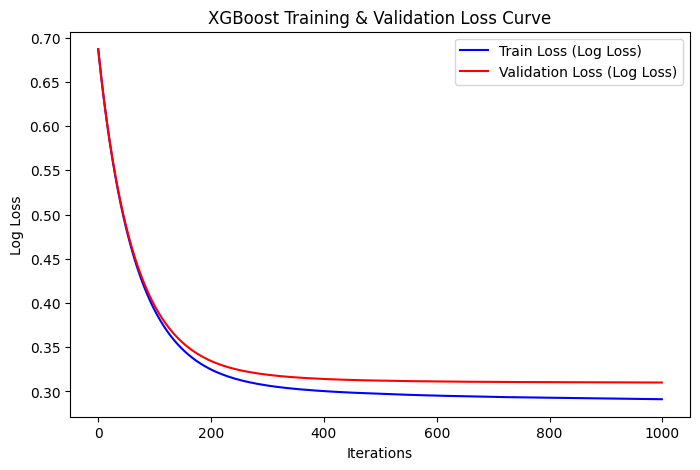

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    599114
           1       0.61      0.91      0.73    145192

    accuracy                           0.87    744306
   macro avg       0.79      0.88      0.82    744306
weighted avg       0.90      0.87      0.88    744306



In [143]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

## Base modeling

In [140]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [141]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [142]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [143]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model_base = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49199	validation_1-logloss:0.49202
[1]	validation_0-logloss:0.48743	validation_1-logloss:0.48748
[2]	validation_0-logloss:0.48299	validation_1-logloss:0.48306
[3]	validation_0-logloss:0.47867	validation_1-logloss:0.47876
[4]	validation_0-logloss:0.47446	validation_1-logloss:0.47458
[5]	validation_0-logloss:0.47036	validation_1-logloss:0.47049
[6]	validation_0-logloss:0.46636	validation_1-logloss:0.46651
[7]	validation_0-logloss:0.46245	validation_1-logloss:0.46262
[8]	validation_0-logloss:0.45864	validation_1-logloss:0.45883
[9]	validation_0-logloss:0.45492	validation_1-logloss:0.45513
[10]	validation_0-logloss:0.45129	validation_1-logloss:0.45151
[11]	validation_0-logloss:0.44774	validation_1-logloss:0.44798
[12]	validation_0-logloss:0.44427	validation_1-logloss:0.44453
[13]	validation_0-logloss:0.44088	validation_1-logloss:0.44115
[14]	validation_0-logloss:0.43756	validation_1-logloss:0.43785
[15]	validation_0-logloss:0.43431	validation_1-logloss:0.43462
[1

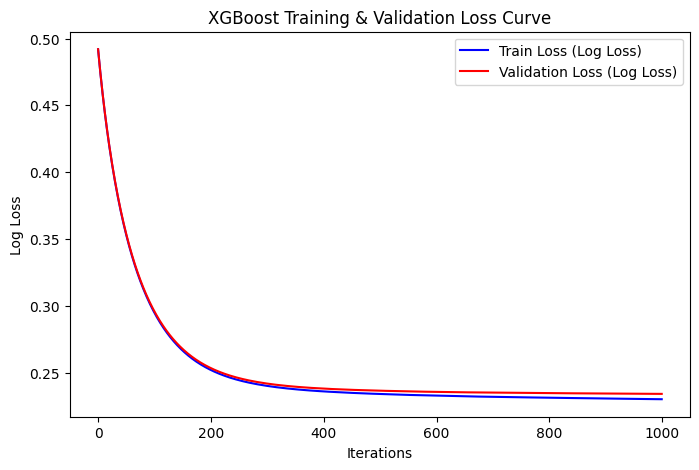

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    299557
           1       0.74      0.75      0.74     72596

    accuracy                           0.90    372153
   macro avg       0.84      0.84      0.84    372153
weighted avg       0.90      0.90      0.90    372153



In [144]:
model_base.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model_base.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model_base.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

## Dataset을 줄여보자
- 전체 데이터셋에서 만들어진 90만 개 데이터 중에서 30만개
- 0.3~0.6으로 만들어진 데이터 20만개 
- class 0는 undersampling 적용

In [144]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [145]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [172]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [173]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [24]:
y_train.value_counts()

loan_status
0              718935
1              174231
Name: count, dtype: int64

In [174]:
#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smotified_fake_data.csv"
fake = pd.read_csv(fake_path)
#fake['loan_status'] = 1

In [96]:
## Term months preprocessing
def term_months(x):
    return 36 if abs(x-36)<abs(x-60) else 60

fake['term_months'] = fake['term_months'].apply(term_months)

In [162]:
fake_Classification = fake.copy()
#fake_Classification = fake_Classification.drop(columns = keep_features)

In [ ]:
"""##fake 데이터 50만개로 줄이기
fake_50K = fake_Classification.sample(n = 400000, random_state=42).reset_index(drop=True)"""

In [150]:
len(fake_Classification)

559051

In [175]:
"""X_fake = fake_50K.drop(columns='loan_status')
y_fake = fake_50K[['loan_status']]"""

X_fake = fake_Classification.drop(columns='loan_status')
y_fake = fake_Classification[['loan_status']]

In [176]:
# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_fake)
y_prob = model.predict_proba(X_fake)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_fake_df = X_fake.copy()
X_fake_df['y_prob'] = y_prob
X_fake_df['y_pred'] = y_pred
X_fake_df['actual'] = y_fake.values

#0.5이상인 것들 확인인
filtered_fake = X_fake_df[(X_fake_df['actual'] == 1)&
                     (X_fake_df['y_prob']>=0)&
                     (X_fake_df['y_prob']<=0.9)]

print(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered_fake)}")
display(filtered_fake.head()) 

⚠️ 조건에 맞는 샘플 개수: 304535


,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,credit_history_years,y_prob,y_pred,actual
1,606.467660,260.023748,0.146653,139593.937674,9.399058,912.444719,145.623292,0.844965,663.510660,24730.828001,19200.865028,87.725075,9465.000000,22.0,0.817628,1,1
5,565.450653,149.914985,0.112306,49357.854439,17.162755,147.630000,860.505452,0.103985,715.635432,16435.739885,2031.000000,10.115702,2000.370959,11.0,0.804157,1,1
6,678.324906,252.835557,0.124236,42853.993587,32.010000,131.546052,696.113697,0.091466,771.175143,20196.320627,2227.860468,35.177348,4344.800787,19.0,0.340154,0,1
7,644.087621,297.838442,0.114440,103411.556695,19.801804,288.421109,807.484905,0.495788,691.756510,41578.883573,13816.392985,56.277966,40826.324341,20.0,0.478737,0,1
10,512.250554,106.364686,0.113787,48121.622649,14.753938,89.440000,599.176998,0.950233,682.242778,11862.214726,9594.823461,94.027394,6380.630425,9.0,0.897680,1,1


In [177]:
drop_columns = ['y_prob', 'y_pred', 'actual']
filtered_fake = filtered_fake.drop(columns=drop_columns)

filtered_fake['loan_status'] = 1

In [155]:
## 0<x<0.7 fake dataset
fake_path2 = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/filter2/filter2_OI_11_00_fake.csv"
fake2 = pd.read_csv(fake_path2)
fake2['loan_status'] = 1

In [104]:
len(fake2)

600000

In [156]:
fake2_20K = fake2.sample(n = 200000, random_state=42).reset_index(drop=True)

In [163]:
filtered_fake.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'credit_history_years', 'loan_status'],
      dtype='object')

In [162]:
fake2_20K.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util',
       'revol_bal', 'total_acc', 'credit_history_years', 'loan_status'],
      dtype='object')

In [57]:
"""X_fake2 = fake2.drop(columns='loan_status')
y_fake2 = fake2[['loan_status']]"""

"""# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_fake)
y_prob = model.predict_proba(X_fake2)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

X_fake_df2 = X_fake2.copy()
X_fake_df2['y_prob'] = y_prob
X_fake_df2['y_pred'] = y_pred
X_fake_df2['actual'] = y_fake2.values

#0.5이상인 것들 확인인
filtered2 = X_fake_df2[(X_fake_df2['actual'] == 1)&
                     (X_fake_df2['y_prob']>=0.5)]

print(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered2)}")
display(filtered2.head())  # Jupyter 환경이면 이렇게"""

'# 5️⃣ 예측 및 평가\n#y_pred = model.predict(X_fake)\ny_prob = model.predict_proba(X_fake2)[:, 1]  # ROC Curve & PRC에 필요\n\nthreshold = 0.5\ny_pred = (y_prob >= threshold).astype(int)\n\nX_fake_df2 = X_fake2.copy()\nX_fake_df2[\'y_prob\'] = y_prob\nX_fake_df2[\'y_pred\'] = y_pred\nX_fake_df2[\'actual\'] = y_fake2.values\n\n#0.5이상인 것들 확인인\nfiltered2 = X_fake_df2[(X_fake_df2[\'actual\'] == 1)&\n                     (X_fake_df2[\'y_prob\']>=0.5)]\n\nprint(f"⚠️ 조건에 맞는 샘플 개수: {len(filtered2)}")\ndisplay(filtered2.head())  # Jupyter 환경이면 이렇게'

In [50]:
fake_path3 = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/test_A/test_A_OI_11_00_fake.csv"
fake3 = pd.read_csv(fake_path3)
fake3['loan_status'] = 1

In [14]:
len(fake3)

600000

In [51]:
fake3_10K = fake3.sample(n = 100000, random_state=42).reset_index(drop=True)

In [178]:
from sklearn.utils import shuffle

#fake_dataset = pd.concat([filtered_fake, fake2_20K])
#fake_total = pd.concat([fake_dataset,fake3_10K])

train_dataset = pd.concat([X_train, y_train], axis=1)

train_total = pd.concat([train_dataset,filtered_fake])
train_total = shuffle(train_total, random_state=42)

In [29]:
fake2['loan_status'].value_counts()

loan_status
1    500000
Name: count, dtype: int64

In [179]:
train_total['loan_status'].value_counts()

loan_status
0    718935
1    478766
Name: count, dtype: int64

In [180]:
X_train = train_total.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = train_total[['loan_status']]  # Target (타겟 변수)

In [181]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
X_train = augmentation_data.drop(columns='loan_status')
y_train = augmentation_data[['loan_status']]

In [182]:
y_train.value_counts()

loan_status
0              718935
1              718935
Name: count, dtype: int64

In [168]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              718935
1              478766
Name: count, dtype: int64
Original data size: 1116458 samples
Undersampled data size: 957532 samples

Undersampling imbalance check
loan_status
0    478766
1    478766
Name: count, dtype: int64


In [169]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산

"""# 1️⃣ XGBoost 모델 정의
model2 = XGBClassifier(
    tree_method='hist',           # 큰 데이터에 적합
    grow_policy='lossguide',      # 깊이보다 손실 감소 기준으로 split
    max_leaves=64,                # 최대 리프 노드 개수
    learning_rate=0.01,
    n_estimators=500,
    eval_metric='logloss',
    random_state=42
)"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model2 = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=800,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68712	validation_1-logloss:0.68727
[1]	validation_0-logloss:0.68122	validation_1-logloss:0.68151
[2]	validation_0-logloss:0.67542	validation_1-logloss:0.67587
[3]	validation_0-logloss:0.66975	validation_1-logloss:0.67034
[4]	validation_0-logloss:0.66418	validation_1-logloss:0.66492
[5]	validation_0-logloss:0.65872	validation_1-logloss:0.65961
[6]	validation_0-logloss:0.65336	validation_1-logloss:0.65436
[7]	validation_0-logloss:0.64806	validation_1-logloss:0.64922
[8]	validation_0-logloss:0.64288	validation_1-logloss:0.64419
[9]	validation_0-logloss:0.63778	validation_1-logloss:0.63926
[10]	validation_0-logloss:0.63275	validation_1-logloss:0.63437
[11]	validation_0-logloss:0.62785	validation_1-logloss:0.62963
[12]	validation_0-logloss:0.62302	validation_1-logloss:0.62497
[13]	validation_0-logloss:0.61826	validation_1-logloss:0.62034
[14]	validation_0-logloss:0.61364	validation_1-logloss:0.61587
[15]	validation_0-logloss:0.60905	validation_1-logloss:0.61142
[1

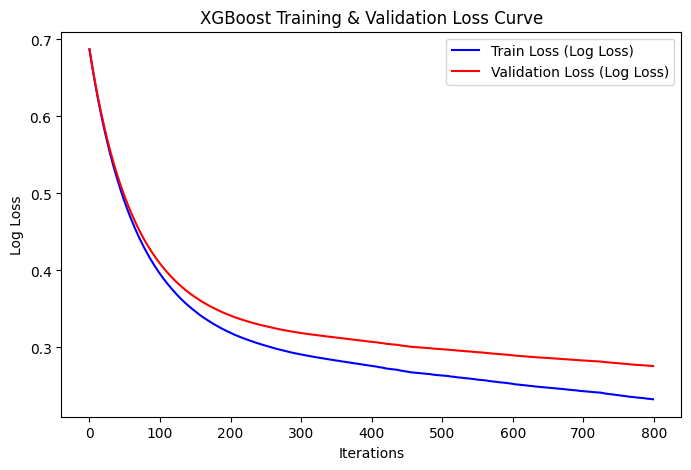

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    599114
           1       0.64      0.87      0.74    145192

    accuracy                           0.88    744306
   macro avg       0.80      0.88      0.83    744306
weighted avg       0.90      0.88      0.88    744306



In [193]:
model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model2.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model2.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [90]:
# 시리즈 형태로 변환
y_test_array = y_test.squeeze()         # 또는 y_test.values.ravel()
y_pred_array = y_pred.squeeze()         # 또는 y_pred.values.ravel()
y_prob_array = y_prob.squeeze()         # 확률도 마찬가지

# 틀린 인덱스 찾기
wrong_indices = np.where(y_test_array != y_pred_array)[0]

# 틀린 케이스와 예측 확률 추출
wrong_cases = X_test.iloc[wrong_indices]
wrong_probs = y_prob_array[wrong_indices]

print("틀린 샘플 수:", len(wrong_cases))
print("틀린 예측 확률 분포:")
print(pd.Series(wrong_probs).describe())

틀린 샘플 수: 88485
틀린 예측 확률 분포:
count    88485.000000
mean         0.609694
std          0.236265
min          0.006489
25%          0.512521
50%          0.676403
75%          0.786135
max          0.983214
dtype: float64


In [106]:
# 시리즈 형태로 변환
y_test_array = y_test.squeeze()         # 또는 y_test.values.ravel()
y_pred_array = y_pred.squeeze()         # 또는 y_pred.values.ravel()
y_prob_array = y_prob.squeeze()         # 확률도 마찬가지

# 틀린 인덱스 찾기
wrong_indices2 = np.where(y_test_array != y_pred_array)[0]

# 틀린 케이스와 예측 확률 추출
wrong_cases2 = X_test.iloc[wrong_indices2]
wrong_probs2 = y_prob_array[wrong_indices2]

print("틀린 샘플 수:", len(wrong_cases2))
print("틀린 예측 확률 분포:")
print(pd.Series(wrong_probs2).describe())

틀린 샘플 수: 89436
틀린 예측 확률 분포:
count    89436.000000
mean         0.602037
std          0.225751
min          0.005615
25%          0.518676
50%          0.666716
75%          0.771493
max          0.953683
dtype: float64


In [114]:
wrong_cases['loan_status'] = np.where(wrong_probs > 0.5, 0, 1)
wrong_cases2['loan_status'] = np.where(wrong_probs2 > 0.5, 0, 1)

In [111]:
wrong_probs2

array([0.80750895, 0.8209699 , 0.5648945 , ..., 0.03653519, 0.83524   ,
       0.08787213], dtype=float32)

In [113]:
wrong_cases2

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,credit_history_years,loan_status
3,544.0,52.000000,0.1646,35000.0,12.04,247.70,321.0,0.303,695.0,20700.00000,6270.0,47.900000,1234.000000,10,0
8,564.0,75.000000,0.2020,35000.0,28.74,266.06,574.0,0.782,710.0,11500.00000,8992.0,75.800000,12302.000000,6,0
13,584.0,180.629118,0.1242,100000.0,20.11,334.16,300.0,0.849,680.0,33823.97164,14688.0,58.157757,13588.188308,8,0
21,579.0,270.000000,0.0789,37000.0,22.35,219.00,325.0,0.523,720.0,24900.00000,13033.0,56.900000,7023.000000,23,0
23,654.0,101.000000,0.1505,70000.0,39.77,867.25,917.0,0.353,725.0,31500.00000,11127.0,35.300000,8270.000000,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744274,639.0,116.000000,0.1952,32284.0,25.63,487.34,799.0,0.463,690.0,6800.00000,3151.0,9.600000,13618.000000,14,1
744283,584.0,180.629118,0.1922,109000.0,13.24,1286.86,331.0,0.968,730.0,33823.97164,6773.0,96.800000,13588.188308,13,0
744285,734.0,180.629118,0.0932,52000.0,16.59,278.74,863.0,0.411,755.0,33823.97164,43232.0,58.157757,13588.188308,15,1
744300,549.0,128.000000,0.1699,75000.0,25.28,1176.38,200.0,0.580,690.0,51900.00000,30084.0,53.000000,5058.000000,11,0


In [115]:
# 1. 두 DataFrame의 교집합 추출 (row-wise)
common_wrong_cases = pd.merge(wrong_cases, wrong_cases2, how='inner')

# 2. 결과 확인
print(f"완전히 일치하는 틀린 샘플 수: {len(common_wrong_cases)}")
common_wrong_cases.head()

완전히 일치하는 틀린 샘플 수: 84987


,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,credit_history_years,loan_status
0,544.0,52.000000,0.1646,35000.0,12.04,247.70,321.0,0.303,695.0,20700.00000,6270.0,47.900000,1234.000000,10,0
1,564.0,75.000000,0.2020,35000.0,28.74,266.06,574.0,0.782,710.0,11500.00000,8992.0,75.800000,12302.000000,6,0
2,584.0,180.629118,0.1242,100000.0,20.11,334.16,300.0,0.849,680.0,33823.97164,14688.0,58.157757,13588.188308,8,0
3,579.0,270.000000,0.0789,37000.0,22.35,219.00,325.0,0.523,720.0,24900.00000,13033.0,56.900000,7023.000000,23,0
4,654.0,101.000000,0.1505,70000.0,39.77,867.25,917.0,0.353,725.0,31500.00000,11127.0,35.300000,8270.000000,15,0


In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model2 = XGBClassifier(
    tree_method='hist',           # 큰 데이터에 적합
    grow_policy='lossguide',      # 깊이보다 손실 감소 기준으로 split
    max_leaves=64,                # 최대 리프 노드 개수
    learning_rate=0.01,
    n_estimators=500,
    eval_metric='logloss',
    random_state=42
)

"""import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model_base = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)"""

'import numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom xgboost import XGBClassifier\n\n#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환\n#scale_pos_weight = neg / pos  # 클래스 비율 계산\n\n# 1️⃣ XGBoost 모델 정의\nmodel_base = XGBClassifier(\n    #scale_pos_weight=scale_pos_weight, \n    n_estimators=1000,\n    learning_rate=0.01,\n    objective=\'binary:logistic\',\n    eval_metric="logloss",\n    random_state=42,\n    verbose = True\n)'

[0]	validation_0-logloss:0.65889	validation_1-logloss:0.57030
[1]	validation_0-logloss:0.65435	validation_1-logloss:0.56620
[2]	validation_0-logloss:0.64988	validation_1-logloss:0.56219
[3]	validation_0-logloss:0.64551	validation_1-logloss:0.55823
[4]	validation_0-logloss:0.64122	validation_1-logloss:0.55435
[5]	validation_0-logloss:0.63702	validation_1-logloss:0.55053
[6]	validation_0-logloss:0.63288	validation_1-logloss:0.54677
[7]	validation_0-logloss:0.62883	validation_1-logloss:0.54309
[8]	validation_0-logloss:0.62484	validation_1-logloss:0.53948
[9]	validation_0-logloss:0.62089	validation_1-logloss:0.53590
[10]	validation_0-logloss:0.61707	validation_1-logloss:0.53239
[11]	validation_0-logloss:0.61333	validation_1-logloss:0.52894
[12]	validation_0-logloss:0.60964	validation_1-logloss:0.52554
[13]	validation_0-logloss:0.60603	validation_1-logloss:0.52220
[14]	validation_0-logloss:0.60244	validation_1-logloss:0.51893
[15]	validation_0-logloss:0.59892	validation_1-logloss:0.51571
[1

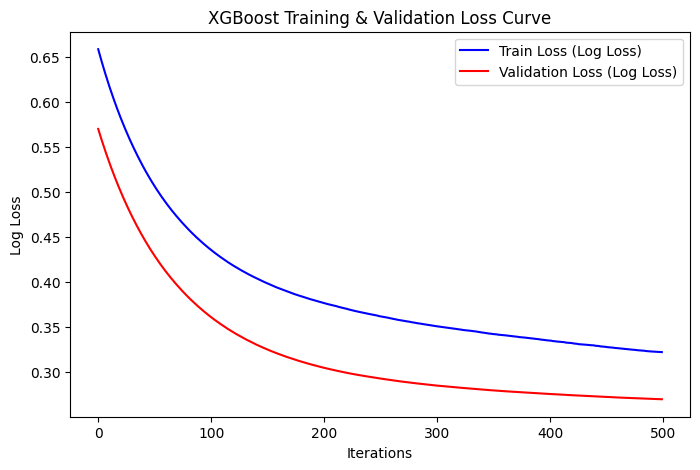

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93    599114
           1       0.67      0.82      0.74    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.86      0.83    744306
weighted avg       0.90      0.89      0.89    744306



In [126]:
model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model2.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model2.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [58]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[525315  73799]
 [ 18228 126964]]

True Positives (TP): 126964
False Positives (FP): 73799
True Negatives (TN): 525315
False Negatives (FN): 18228


## 0.3~0.6과 원래의 fake 데이터셋 분석

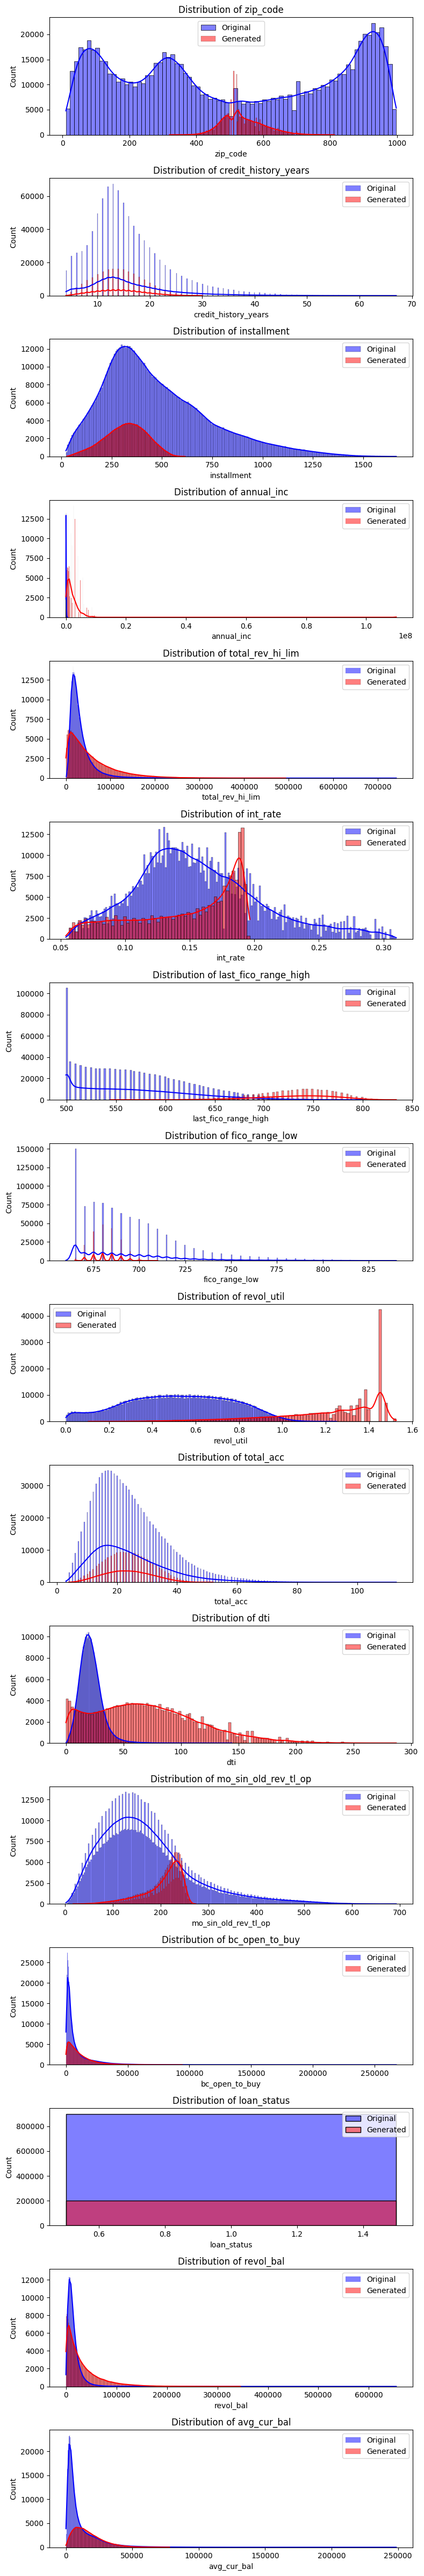

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(fake.columns) & set(fake2.columns))
original_df = fake[common_features]
generated_df = fake2[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()